# Parallelization

Even for large cases _foxes_ calculations are fast, thanks to

- **Vectorization:** The states (and also the points, in the case of data calculation at evaluation points) are split into so-called _chunks_, which are sub-arrays of the large original data.
- **Parallelization:** These chunks are being sent to individual processes for calculation. Those calculations can be carried out simultaneously, i.e., _in parallel_.  

Vectorization and parallelization are managed by so-called _engines_ in _foxes_. If you do not explicitly specify the engine, a default will be chosen. This means that even if you do not know or care about _foxes_ engines, your calculations will be vectorized and parallelized.

## Available engines

These are the currently available engines, where each can be addressed by the short name or the full class name:

| Short name    | Class name         | Base package | Description                        |
|---------------|--------------------|--------------|------------------------------------| 
| threads       | ThreadsEngine      | [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) | Runs on a workstation/laptop,  sends chunks to threads |
| process       | ProcessEngine      | [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) | Runs on a workstation/laptop,  sends chunks to parallel processes |
| multiprocess  | MultiprocessEngine | [multiprocess](https://github.com/uqfoundation/multiprocess) |  Runs on a workstation/laptop,  sends chunks to parallel processes |
| ray  | RayEngine | [ray](hhttps://docs.ray.io/en/latest/) |  Runs on a workstation/laptop,  sends chunks to parallel processes |
| dask          | DaskEngine         | [dask](https://www.dask.org/) | Runs on a workstation/laptop, using processes or threads |
| local_cluster | LocalClusterEngine | [distributed](https://distributed.dask.org/en/stable/) | Runs on a workstation/laptop, creates a virtual local cluster |
| slurm_cluster | SlurmClusterEngine | [dask_jobqueue](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html) | Runs on a multi-node HPC cluster which is using SLURM |
| mpi           | MPIEngine          | [mpi4py](https://mpi4py.readthedocs.io/en/stable/index.html) | Runs on laptop/workstation/cluster, also supports multi-node runs |
| numpy         | NumpyEngine        | [numpy](https://numpy.org/) | Runs a loop over chunks, without parallelization |
| single        | SingleChunkEngine  | [numpy](https://numpy.org/) | Runs all in a single chunk, without parallelization |
| default       | DefaultEngine      | [numpy](https://numpy.org/), [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) | Runs either the `single` or the `process` engine, depending on the case size |

Note that the external packages are not installed by default. You can install them manually on demand, or use the option `pip install foxes[eng]` for the complete installation of all requirements of the complete list of engines.

Furthermore, scripts that use the `mpi` engine have to be started in a special way. For example, when running a script named `run.py` on 12 processors, the terminal command is
```console
mpiexec -n 12 python -m mpi4py.futures run.py
```

## Default engine

Let's start by importing _foxes_ and other required packages:

In [1]:
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

Next, we create a random wind farm and a random time series:

In [2]:
n_times = 5000
n_turbines = 100
seed = 42

sdata = foxes.input.states.create.random_timseries_data(
    n_times,
    seed=seed,
)
states = foxes.input.states.Timeseries(
    data_source=sdata,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.02},
)

farm = foxes.WindFarm()
foxes.input.farm_layout.add_random(
    farm, n_turbines, min_dist=500, turbine_models=["DTU10MW"], seed=seed, verbosity=0
)

In [3]:
sdata

,WS,WD
Time,,
2000-01-01 00:00:00,11.236204,141.708787
2000-01-01 01:00:00,28.521429,170.436837
2000-01-01 02:00:00,21.959818,307.637062
2000-01-01 03:00:00,17.959755,122.401579
2000-01-01 04:00:00,4.680559,313.073887
...,...,...
2000-07-27 03:00:00,26.921920,308.756156
2000-07-27 04:00:00,3.581430,323.103181
2000-07-27 05:00:00,9.835285,340.814849


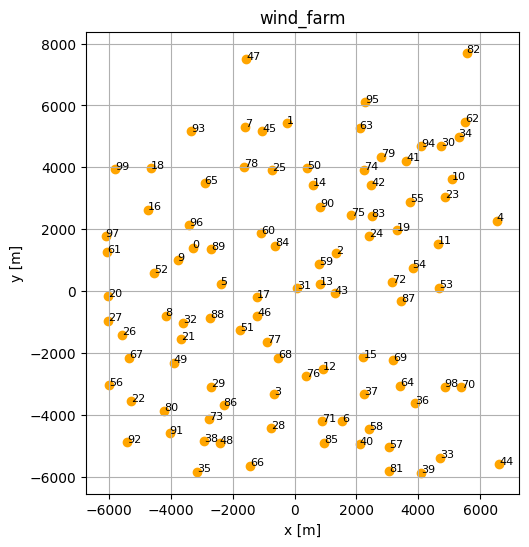

In [4]:
foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(6, 6))
plt.show()

You can run the wind farm calculations by simply creating an algorithm and calling _farm\_calc_:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    wake_models=["Bastankhah2014_linear_k004"],
    verbosity=1,
)

In [6]:
farm_results = algo.calc_farm()
farm_results

Initializing model 'Timeseries'

Initializing algorithm 'Downwind'

------------------------------------------------------------
  Algorithm: Downwind
  Running Downwind: calc_farm
------------------------------------------------------------
  n_states : 5000
  n_turbines: 100
------------------------------------------------------------
  states    : Timeseries()
  rotor     : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
  deflection: NoDeflection()
------------------------------------------------------------
  wakes:
    0) Bastankhah2014_linear_k004: Bastankhah2014(ws_linear, induction=Madsen, k=0.04)
------------------------------------------------------------
  partial wakes:
    0) Bastankhah2014_linear_k004: axiwake6, PartialAxiwake(n=6)
------------------------------------------------------------
  turbine models:
    0) DTU10MW: PCtFile(D=178.3, H=119.0, P_nominal=10000.0, P_unit=kW, rho=1.225, var_ws_ct=REWS2, var_ws_P=REWS3)
----------------------

ProcessEngine: Computing 15 chunks using 15 workers


  0%|                                                                                                   | 0/15 [00:00<?, ?it/s]

  7%|██████                                                                                     | 1/15 [00:07<01:42,  7.34s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s]

ProcessEngine: Completed all 15 chunks





<xarray.Dataset> Size: 100MB
Dimensions:     (state: 5000, turbine: 100)
Coordinates:
  * state       (state) datetime64[ns] 40kB 2000-01-01 ... 2000-07-27T07:00:00
Dimensions without coordinates: turbine
Data variables: (12/27)
    AMB_CT      (state, turbine) float64 4MB 0.758 0.758 0.758 ... 0.1502 0.1502
    AMB_P       (state, turbine) float64 4MB 9.921e+03 9.921e+03 ... 1.064e+04
    AMB_REWS    (state, turbine) float64 4MB 11.24 11.24 11.24 ... 17.92 17.92
    AMB_REWS2   (state, turbine) float64 4MB 11.24 11.24 11.24 ... 17.92 17.92
    AMB_REWS3   (state, turbine) float64 4MB 11.24 11.24 11.24 ... 17.92 17.92
    AMB_RHO     (state, turbine) float64 4MB 1.225 1.225 1.225 ... 1.225 1.225
    ...          ...
    YAW         (state, turbine) float64 4MB 141.7 141.7 141.7 ... 78.17 78.17
    order       (state, turbine) int64 4MB 44 33 39 81 57 70 ... 22 20 27 92 56
    order_inv   (state, turbine) int64 4MB 76 77 54 75 85 15 ... 16 21 89 39 71
    order_ssel  (state, turbine) int64 4MB 0 0 0 0 0 0 ... 333 333 333 333 333
    weight      (state) float64 40kB 0.0002 0.0002 0.0002 ... 0.0002 0.0002
    tname       (turbine) <U3 1kB 'T0' 'T1' 'T2' 'T3' ... 'T97' 'T98' 'T99'

During the very first calculation, the algorithm checks if an engine is already up and running. If not, the default engine is created. We can check the currently active engine by the following function:

In [7]:
foxes.get_engine()

DefaultEngine(n_procs=16, chunk_size_states=None, chunk_size_points=None)

This shows that the default choice is the _DefaultEngine_, which selected to run the _ProcessEngine_ for this size of problem. The criteria are:

- If `n_states >= sqrt(n_procs) * (500/n_turbines)**1.5`: Run engine `ProcessEngine`,
- Else if `algo.calc_points()` has been called and `n_states*n_points > 10000`: Run engine `ProcessEngine`,
- Else: Run engine `SingleChunkEngine`.

The above selection is based on test runs on a Ubuntu workstation with 64 physical cores and might not be the optimal choice for your system. Be aware of this whenever relying on the default engine for smallish cases - if in doubt, better explicitly specify the engine.

Note that the parameter choice _None_ for the chunk sizes represents a default choice by the engine, and does not mean that there is no chunking in the corresponding dimension.

We can reset the engine by

In [8]:
foxes.reset_engine()

such that no engine is active afterwards:

In [9]:
print(foxes.get_engine(error=False, default=False))

None


## Engine selection through the algorithm

There are two ways how to select a non-default engine and set all its parameters, as we will explore in this and the following section. 

If you are using one algorithm for all calculations, you can select the engine directly via the algorithm's constructor. Make sure the algorithm is created at the beginning of your script, in particular before creating images, since those might launch the default engine otherwise.

In [10]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    wake_models=["Bastankhah2014_linear_k004"],
    engine="dask",
    n_procs=2,
    chunk_size_states=2000,
    chunk_size_points=4000,
    verbosity=1,
)

Algorithm 'Downwind': Selecting engine 'DaskEngine(n_procs=2, chunk_size_states=2000, chunk_size_points=4000)'


Here the _DaskEngine_ class was selected, with _n\_procs_ value 2 and a user choice of chunk sizes. Notice that the short name from the above table can be used instead of the full class name (which, however, would also work).

For the complete list of constructor arguments of each of the engine classes, please check the API section _foxes.engines_. Any argument of the engine constructor can directly be added to the constructor of the algorithm, and will then be passed on.

Let's re-run the calculation using the above selected engine:

In [11]:
farm_results = algo.calc_farm()

Initializing model 'Timeseries'

Initializing algorithm 'Downwind'

------------------------------------------------------------
  Algorithm: Downwind
  Running Downwind: calc_farm
------------------------------------------------------------
  n_states : 5000
  n_turbines: 100
------------------------------------------------------------
  states    : Timeseries()
  rotor     : CentreRotor()
  controller: BasicFarmController()
  wake frame: RotorWD()
  deflection: NoDeflection()
------------------------------------------------------------
  wakes:
    0) Bastankhah2014_linear_k004: Bastankhah2014(ws_linear, induction=Madsen, k=0.04)
------------------------------------------------------------
  partial wakes:
    0) Bastankhah2014_linear_k004: axiwake6, PartialAxiwake(n=6)
------------------------------------------------------------
  turbine models:
    0) DTU10MW: PCtFile(D=178.3, H=119.0, P_nominal=10000.0, P_unit=kW, rho=1.225, var_ws_ct=REWS2, var_ws_P=REWS3)
----------------------

[                                        ] | 0% Completed | 2.04 s

[                                        ] | 0% Completed | 2.14 s

[                                        ] | 0% Completed | 2.25 s

[                                        ] | 0% Completed | 2.35 s

[                                        ] | 0% Completed | 2.45 s

[                                        ] | 0% Completed | 2.56 s

[                                        ] | 0% Completed | 2.66 s

[                                        ] | 0% Completed | 2.76 s

[                                        ] | 0% Completed | 2.87 s

[                                        ] | 0% Completed | 2.97 s

[                                        ] | 0% Completed | 3.07 s

[                                        ] | 0% Completed | 3.18 s

[                                        ] | 0% Completed | 3.28 s

[                                        ] | 0% Completed | 3.38 s

[                                        ] | 0% Completed | 3.49 s

[                                        ] | 0% Completed | 3.59 s

[                                        ] | 0% Completed | 3.70 s

[                                        ] | 0% Completed | 3.80 s

[                                        ] | 0% Completed | 3.90 s

[                                        ] | 0% Completed | 4.01 s

[                                        ] | 0% Completed | 4.11 s

[                                        ] | 0% Completed | 4.21 s

[                                        ] | 0% Completed | 4.32 s

[                                        ] | 0% Completed | 4.42 s

[                                        ] | 0% Completed | 4.53 s

[                                        ] | 0% Completed | 4.63 s

[                                        ] | 0% Completed | 4.73 s

[                                        ] | 0% Completed | 4.83 s

[                                        ] | 0% Completed | 4.94 s

[                                        ] | 0% Completed | 5.04 s

[                                        ] | 0% Completed | 5.14 s

[                                        ] | 0% Completed | 5.25 s

[                                        ] | 0% Completed | 5.35 s

[                                        ] | 0% Completed | 5.45 s

[                                        ] | 0% Completed | 5.56 s

[                                        ] | 0% Completed | 5.66 s

[                                        ] | 0% Completed | 5.76 s

[                                        ] | 0% Completed | 5.87 s

[                                        ] | 0% Completed | 5.97 s

[                                        ] | 0% Completed | 6.07 s

[                                        ] | 0% Completed | 6.18 s

[                                        ] | 0% Completed | 6.28 s

[                                        ] | 0% Completed | 6.38 s

[                                        ] | 0% Completed | 6.48 s

[                                        ] | 0% Completed | 6.59 s

[                                        ] | 0% Completed | 6.69 s

[                                        ] | 0% Completed | 6.79 s

[                                        ] | 0% Completed | 6.90 s

[                                        ] | 0% Completed | 7.00 s

[                                        ] | 0% Completed | 7.10 s

[                                        ] | 0% Completed | 7.21 s

[                                        ] | 0% Completed | 7.31 s

[                                        ] | 0% Completed | 7.42 s

[                                        ] | 0% Completed | 7.52 s

[                                        ] | 0% Completed | 7.62 s

[                                        ] | 0% Completed | 7.73 s

[                                        ] | 0% Completed | 7.83 s

[                                        ] | 0% Completed | 7.93 s

[                                        ] | 0% Completed | 8.04 s

[                                        ] | 0% Completed | 8.14 s

[                                        ] | 0% Completed | 8.25 s

[                                        ] | 0% Completed | 8.35 s

[                                        ] | 0% Completed | 8.45 s

[                                        ] | 0% Completed | 8.55 s

[                                        ] | 0% Completed | 8.66 s

[                                        ] | 0% Completed | 8.76 s

[                                        ] | 0% Completed | 8.86 s

[                                        ] | 0% Completed | 8.97 s

[#############                           ] | 33% Completed | 9.07 s

[##########################              ] | 66% Completed | 9.18 s

[##########################              ] | 66% Completed | 9.28 s

[########################################] | 100% Completed | 9.38 s

DaskEngine: Combining results from 3 chunks




We can always check the current engine, and reset it if desired:

In [12]:
foxes.get_engine()

DaskEngine(n_procs=2, chunk_size_states=2000, chunk_size_points=4000)

In [13]:
foxes.reset_engine()
print(foxes.get_engine(error=False, default=None))

None


For a proper shutdown of the applied engine, make sure you do not forget the `foxes.reset_engine()` command after the final calculation. Alternatively, consider the selection of the engine by a `with` block, as explained in the following section. 

## Engine selection through a with-block

The proper way of using an engine is recommended to apply a Python context manager, i.e., a _with_ block, for creating the engine. This ensures the proper shutdown of the engine, and it also increases the readability concerning the engine choice.

Especially for cluster and pool based engines, which have non-trivial shutdown routines, the _with_ block is always preferrable over the algorithm based engine specification.

The syntax is straight forward. Note that within the context block we create the algorithm without any engine specification. Furthermore, note that the engine object is not required as a parameter for the algorithm, since it is set as a globally accessible object during initialization:

Launching local dask cluster..


LocalCluster(a1ff1a00, 'tcp://127.0.0.1:34503', workers=3, threads=18, memory=7.38 GiB)
Dashboard: http://127.0.0.1:8787/status

LocalClusterEngine: Calculating 5000 states for 100 turbines


Submitting 3 chunks to 3 workers
LocalClusterEngine: Computing 3 chunks using 3 workers


  0%|                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████▋                                                             | 1/3 [00:16<00:32, 16.35s/it]

 67%|█████████████████████████████████████████████████████████████▎                              | 2/3 [00:16<00:06,  6.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.52s/it]

LocalClusterEngine: Completed all 3 chunks

LocalClusterEngine: Calculating data at 223533 points for 1 states
Submitting 23 chunks to 3 workers


LocalClusterEngine: Computing 23 chunks using 3 workers


  0%|                                                                                                   | 0/23 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 172.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 167.46it/s]

LocalClusterEngine: Completed all 23 chunks



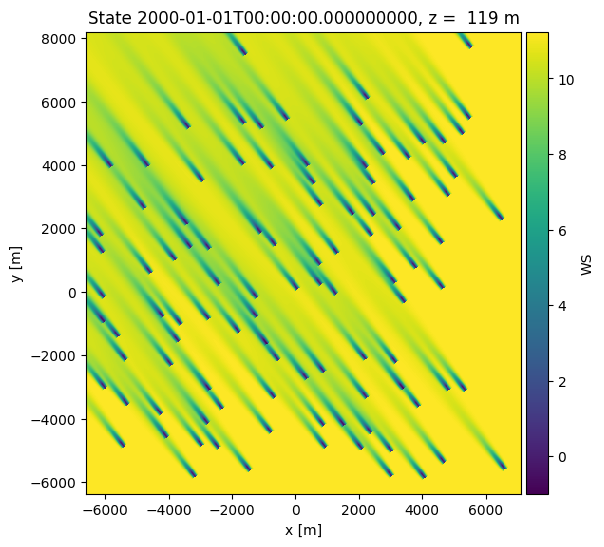

Shutting down LocalCluster


In [14]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    wake_models=["Bastankhah2014_linear_k004"],
    verbosity=0,
)

with foxes.Engine.new(
    "local_cluster", n_procs=4, chunk_size_states=2000, chunk_size_points=10000
):
    farm_results = algo.calc_farm()

    o = foxes.output.FlowPlots2D(algo, farm_results)
    g = o.gen_states_fig_xy(FV.WS, resolution=30, figsize=(6, 6), states_isel=[0])
    next(g)
    plt.show()

Notice the _Dashboard_ link which for this particular choice of engine displays the progress and cluster load during the execution. 

After the computation the engine is not set, as expected:

In [15]:
print(foxes.get_engine(error=False, default=False))

None


## Manual engine selection

It can be useful to create the `Engine` object manually, especially when working in a notebook. In that case the engine is often needed many times, and switching it on and off again all the time is not very efficient. 

For such cases, create the engine in the beginning and initialize it:

In [16]:
engine = foxes.Engine.new("process", n_procs=4, chunk_size_states=2000)
engine.initialize()

Afterwards, run all of your code with that engine:

In [17]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    wake_models=["Bastankhah2014_linear_k004"],
    verbosity=0,
)

farm_results = algo.calc_farm()
print(farm_results[FV.REWS])

ProcessEngine: Calculating 5000 states for 100 turbines


ProcessEngine: Computing 3 chunks using 3 workers


  0%|                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████▋                                                             | 1/3 [00:10<00:20, 10.16s/it]

 67%|█████████████████████████████████████████████████████████████▎                              | 2/3 [00:10<00:04,  4.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.49s/it]

ProcessEngine: Completed all 3 chunks

<xarray.DataArray 'REWS' (state: 5000, turbine: 100)> Size: 4MB
array([[ 8.70739148, 10.4023241 , 10.85525979, ..., 10.02214303,
        10.86887979,  9.08783168],
       [28.52142919, 28.52142919, 28.52142919, ..., 28.52142919,
        28.52142919, 28.52142919],
       [21.76458387, 21.95981825, 21.91921633, ..., 21.95981825,
        21.76465933, 21.95981825],
       ...,
       [ 8.95387404,  9.83495453,  7.70073211, ...,  9.83528514,
         9.0447358 ,  9.83528514],
       [23.97191414, 24.28804821, 24.41856192, ..., 24.20911122,
        24.3769261 , 24.08118561],
       [17.25082391, 17.7526868 , 17.80791824, ..., 17.63554043,
        17.62773546, 17.71363755]], shape=(5000, 100))
Coordinates:
  * state    (state) datetime64[ns] 40kB 2000-01-01 ... 2000-07-27T07:00:00
Dimensions without coordinates: turbine


After everything is done, shutdown the engine:

In [18]:
engine.finalize()

The `engine` object still exists after this, so you can always decide to initialize/finalize it again, if needed.

## Remarks & recommendations

- Take the time to think about your engine choice, and its parameters. Your choice might matter a lot for the performance of your run.
- In general, all engines accept the parameters `n_procs`, `chunk_size_states`, `chunk_size_points` (the `single` engine ignores them, though).
- If `n_procs` is not set, the maximal number of processes is applied, according to `os.cpu_count()` for Python version < 3.13 and `os.process_cpu_count()` for Python version >= 3.13.
- If `chunk_size_states` is not set, the number of states is divided by `n_procs`. This might be non-optimal for small cases.
- If `chunk_size_points` is not set and there is more than one states chunk, the full number of points is selected such that there is only one point chunk for each state chunk. If there is only one states chunk, the default points chunk size is the number of points divided by `n_procs`.
- In general, for not too small cases, the default `process` engine is a good choice for runs on a linux based laptop or a workstation computer, or within Windows WSL.
- For runs on native Windows, i.e., without WSL, the best engine choices have not been tested. Make sure you try different ones, e.g. `process`, `multiprocess`, `dask`, `numpy`, and also vary the parameters.
- The `mpi` engine requires the installation of MPI on the system, for example _OpenMPI_.
- If you run into memory problems, the best options are to either reduce the number of processes or the chunk sizes.
- The `dask` engine has additional options, accessible through the _dask\_pars_ dictionary parameter, for example the _scheduler_ choice. See API and [dask documentation](https://docs.dask.org/en/stable/scheduling.html) for syntax and more info.
- The `local_cluster` is not always faster than the `process`, `multiprocess` or `dask` engines, but offers a more detailed setup. For example, the memory and the number of threads per worker can be modified, if needed.
- The `numpy` and `single` engines are intended for testing and small cases, and also for sequential runs without large point evaluations, or for smallish runs with wake frame `dyn_wakes`.
- In notebooks, the preferred engine selection method is the `Manual engine selection` described above.